https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6
https://papers.nips.cc/paper/2019/file/6775a0635c302542da2c32aa19d86be0-Paper.pdf

In [1]:
USE_TPU=False

if USE_TPU:
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev


    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp   
    import torch_xla.debug.metrics as met

    
    import torch
    import torch.nn as nn
    device=xm.xla_device()
    !pip install -U numpy
else:
    
    import torch
    import torch.nn as nn
    device=torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

print(device)

cuda


In [2]:
import os
import gc
import json
import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
def seed_everything(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.cuda.manual_seed(s)
    torch.backends.cudnn.deterministic=True
    
seed_everything(2012)

In [4]:
class config:
    num_buckets= 600
    num_features= 11
    batch_size=128
    epochs=15

In [9]:
def get_dataset():
    all_df=[]
    train_book_folder = "../input/optiver-realized-volatility-prediction/train_book"
    for i, stock_file in enumerate(os.listdir(train_book_folder)):
        if i%20==0:
            print(i)
        file_path=os.path.join(train_book_folder, stock_file)
        stock_df=pd.read_pickle(file_path)
        all_df.append(stock_df)
    
    book_df=pd.concat(all_df)
    return book_df

book_df=get_dataset()
book_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/optiver-realized-volatility-prediction/train_book'

# Dataset

In [6]:
window=4
def smoothing(x):
    if x.shape[0] < window:
        return x
    x=x.copy()
    try:
        cum_x=np.cumsum(x, axis=0)
        x_rolling=(cum_x[window:, :] - cum_x[:-window, :])/window
        x[window:, :]=x_rolling
    except:
        print('dfsf')
        pass
    return x

def smoothing_1d(x):
    if x.shape[0] < window:
        return x
    x=x.copy()
    try:
        cum_x=np.cumsum(x)
        x_rolling=(cum_x[window:] - cum_x[:-window])/window
        x[window:]=x_rolling
    except:
        pass
    return x

In [7]:
class OptiverDataset(torch.utils.data.Dataset):
    def __init__(self, indices, features, target):
        self.indices=indices
        self.target=target
        self.features=features
        
    def __len__(self):
        return len(self.indices)
    
    def calculate_wap(self, ask_price, bid_price, ask_size, bid_size):
        ask_size=np.exp(ask_size) - 1
        bid_size=np.exp(bid_size) - 1
        wap = (ask_price * bid_size) + (bid_price * ask_size)
        wap = wap / (ask_size + bid_size)
        return wap
    
    def get_log_returns(self, wap):
        s=np.diff(np.log(wap))
        s[s==-np.inf]=0.0
        return s
    
    def get_realized_volatility(self, s):
        rv=np.sqrt(np.sum( (s**2) ))
        return rv
    
    def get_features(self, feat):
        bid_price1=feat[:, 0]
        ask_price1=feat[:, 1]
        bid_price2= feat[:, 2]
        ask_price2= feat[:, 3]
        bid_size1=feat[:, 4]
        ask_size1=feat[:, 5]
        bid_size2=feat[:, 6]
        ask_size2=feat[:, 7]
        
        wap1=self.calculate_wap(ask_price1, bid_price1, ask_size1, bid_size1)
        wap2=self.calculate_wap(ask_price2, bid_price2, ask_size2, bid_size2)
        
        s1=self.get_log_returns(wap1)
        s2=self.get_log_returns(wap2)
        
        rv1=self.get_realized_volatility(s1)
        rv2=self.get_realized_volatility(s2)
        
        if rv1==0:
            rv1=rv2
        elif rv2==0:
            rv2=rv1
        
        return (wap1,wap2, s1, s2, rv1, rv2)
    
    def get_binary_target_features(self, y_target, rv1, rv2):
        y_binary1=(y_target>rv1)
        y_binary2=(y_target>rv2)
        
        weights1=np.abs(y_target - rv1) + 1e-10
        weights2=np.abs(y_target - rv2) + 1e-10
        
        return (y_binary1, y_binary2, weights1, weights2)
        
    
    def get_price_differences(self, feat, seq_len):
        bid_price1=feat[:, 0]
        ask_price1=feat[:, 1]
        bid_price2= feat[:, 2]
        ask_price2= feat[:, 3]
        
        price_diff1 = bid_price1 - ask_price1
        price_diff2 = bid_price2 - ask_price2
        
        ask_diff = ask_price1 - ask_price2
        bid_diff = bid_price1 - bid_price2
        
        price_diff=np.zeros((4, 600) )
        price_diff[0, -seq_len:]=price_diff1
        price_diff[1, -seq_len:]=price_diff2
        price_diff[2, -seq_len:]=ask_diff
        price_diff[3, -seq_len:]=bid_diff
        
        price_diff=torch.tensor(price_diff, dtype=torch.float32).transpose(1, 0)
        return price_diff
    
    def __getitem__(self, idx):
        i=self.indices[idx]
        feat=np.array(self.features[i])
        y_target=self.target[i]
        (seq_len, num_features) = (feat.shape[0], feat.shape[1])
        
        (wap1_arr,wap2_arr, s1_arr, s2_arr, rv1, rv2)=self.get_features(feat)
        price_diff = self.get_price_differences(feat, seq_len)
        ratio=y_target/rv1
        if ratio >=2.23:#99.95 percent ratio - 2.23
            ratio=2.23+np.log(1 + ratio - 2.23)
        
        y_target=ratio * rv1
        (y_binary1, y_binary2, weight1, weight2)=self.get_binary_target_features(y_target, rv1, rv2)
        
        feat=smoothing(feat)
        wap1_arr=smoothing_1d(wap1_arr)
        wap2_arr=smoothing_1d(wap2_arr)
        
        X=torch.zeros(600, num_features)
        
        mask=np.zeros(600)
        mask[-seq_len:]=1
        
        wap1=torch.zeros(600)
        wap2=torch.zeros(600)
        s1=torch.zeros(600)
        s2=torch.zeros(600)
        
        mask=torch.tensor(mask, dtype=torch.long)
        X[-seq_len:]=torch.tensor(feat, dtype=torch.float32)
        wap1[-seq_len:]=torch.tensor(wap1_arr, dtype=torch.float32)
        wap2[-seq_len:]=torch.tensor(wap2_arr, dtype=torch.float32)
        
        s1[-seq_len+1:]=torch.tensor(s1_arr, dtype=torch.float32)
        s2[-seq_len+1:]=torch.tensor(s2_arr, dtype=torch.float32)
        
        weight1=torch.tensor(weight1, dtype=torch.float32)
        weight2=torch.tensor(weight2, dtype=torch.float32)
        
        rv1=torch.tensor(rv1, dtype=torch.float32)
        rv2=torch.tensor(rv2, dtype=torch.float32)
        
        y_binary1=torch.tensor(y_binary1, dtype=torch.float32)
        y_binary2=torch.tensor(y_binary2, dtype=torch.float32)
        
        y_target=torch.tensor(y_target, dtype=torch.float32)
        return (X, price_diff, mask, wap1, wap2, s1, s2, rv1, rv2, weight1, weight2, y_binary1, y_binary2, y_target)

In [8]:
features=book_df.features.values
target=book_df.target.values

del book_df
gc.collect()
print(features.shape, target.shape)

NameError: name 'book_df' is not defined

In [9]:
random.seed(2012)
indices=np.arange(features.shape[0])
random.shuffle(indices)

train_idx=indices[:int(len(indices) * 0.8)]
valid_idx=indices[int(len(indices) * 0.8):]

print(indices.shape, train_idx.shape, valid_idx.shape)

train_dataset=OptiverDataset(train_idx, features, target)
valid_dataset=OptiverDataset(valid_idx, features, target)


train_dataloader=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=0
)

valid_dataloader=torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    num_workers=2
)

print(len(train_dataloader), len(valid_dataloader))


(428932,) (343145,) (85787,)
5361 671


# Model

In [10]:
#https://github.com/KrisKorrel/sparsemax-pytorch

class Sparsemax(nn.Module):
    """Sparsemax function."""

    def __init__(self, dim=None):
        """Initialize sparsemax activation
        
        Args:
            dim (int, optional): The dimension over which to apply the sparsemax function.
        """
        super(Sparsemax, self).__init__()

        self.dim = -1 if dim is None else dim

    def forward(self, input):
        """Forward function.
        Args:
            input (torch.Tensor): Input tensor. First dimension should be the batch size
        Returns:
            torch.Tensor: [batch_size x number_of_logits] Output tensor
        """
        # Sparsemax currently only handles 2-dim tensors,
        # so we reshape to a convenient shape and reshape back after sparsemax
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)

        # Translate input by max for numerical stability
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)

        # Sort input in descending order.
        # (NOTE: Can be replaced with linear time selection method described here:
        # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, device=device, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Determine sparsity of projection
        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        # Compute threshold function
        zs_sparse = is_gt * zs

        # Compute taus
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        # Sparsemax
        self.output = torch.max(torch.zeros_like(input), input - taus)

        # Reshape back to original shape
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)

        return output

    def backward(self, grad_output):
        """Backward function."""
        dim = 1

        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return self.grad_input

In [11]:
sparsemax = Sparsemax(dim=-1)

def get_activation_fn(activation):
    if activation=='gelu':
        return nn.GELU()
    elif activation=='relu':
        return nn.ReLU()
    
def attention(query, key, value, mask=None, dropout=None):
    d_k=query.size(-1)
    scores=torch.matmul( query, key.transpose(-1, -2) )/np.sqrt(d_k)
    #scores=torch.tril(scores)
    if mask is not None:
        scores=scores.masked_fill(mask == 0, -1e9)
    
    #p_attn=torch.softmax(scores, dim=-1)
    p_attn=sparsemax(scores)
    x_attn=torch.matmul(p_attn, value)
    if dropout:
        x_attn=dropout(x_attn)
        
    return p_attn, x_attn

class MultiHeadAttention(nn.Module):
    def __init__(self, num_features, dmodel, nhead,activation,norm,dropout):
        super().__init__()
        self.dmodel=dmodel
        self.nhead=nhead
        self.d_k=dmodel//nhead #Size
        
        self.activation=activation
        self.norm=norm
        self.dropout=dropout
        
        #self.Q=nn.Linear(num_features, dmodel)
        #self.K=nn.Linear(num_features, dmodel)
        #self.V=nn.Linear(num_features, dmodel)
        
        self.Q=nn.Conv1d(num_features, dmodel, 5, padding=2)
        self.K=nn.Conv1d(num_features, dmodel, 5, padding=2)
        self.V=nn.Conv1d(num_features, dmodel, 5, padding=2)
        
        
        self.W=nn.Linear(dmodel, num_features)
        
        #nn.init.uniform_(self.Q.weight, -1/np.sqrt(2*num_features), 1/np.sqrt(2*num_features))
        #nn.init.uniform_(self.K.weight, -1/np.sqrt(2*num_features), 1/np.sqrt(2*num_features))
        #nn.init.uniform_(self.V.weight, -1/np.sqrt(2*num_features), 1/np.sqrt(2*num_features))
        #nn.init.uniform_(self.W.weight, -1/np.sqrt(2*num_features), 1/np.sqrt(2*num_features))
        
        
    def forward(self, x, mask=None):
        bsize=x.size(0)
        x=self.norm(x)
        x=x.transpose(2, 1)
        query=self.Q(x).transpose(2, 1).view(bsize, -1, self.nhead, self.d_k)
        key=self.K(x).transpose(2, 1).view(bsize, -1, self.nhead, self.d_k)
        value=self.V(x).transpose(2, 1).view(bsize, -1, self.nhead, self.d_k)
        mask=mask.unsqueeze(-1).unsqueeze(-1)
        
        #query=self.Q(x).view(bsize, -1, self.nhead, self.d_k)
        #key=self.K(x).view(bsize, -1, self.nhead, self.d_k)
        #value=self.V(x).view(bsize, -1, self.nhead, self.d_k)
        
        
        p_attn, x_attn=attention(query, key, value, mask, self.dropout)
        x_attn=x_attn.view(bsize, -1, self.nhead*self.d_k)
        
        x_attn=self.W(x_attn)
        x=x.transpose(2, 1)
        x=x+x_attn
        return x

class TimeSeriesAttentionLayer(nn.Module):
    def __init__(self,
                 num_features=32,
                 dmodel=128,
                 nhead=4,
                 dim_feed_forward=512,
                 activation='relu', 
                 dropout=0.1
                ):
        
        super().__init__()
        self.num_features=num_features
        self.dmodel=dmodel
        self.nhead=nhead
        self.dim_feed_forward=dim_feed_forward
        self.activation=get_activation_fn('gelu')
        self.norm=nn.LayerNorm(num_features)
        self.dropout=nn.Dropout(dropout)
        
        self.multihead_attn=MultiHeadAttention(num_features,
                                               dmodel,
                                               nhead,
                                               self.activation,
                                               self.norm,
                                               self.dropout
                                              )
        
        self.conv1=nn.Conv1d(num_features, dim_feed_forward, 5, padding=2)
        self.conv2=nn.Conv1d(dim_feed_forward, num_features, 5, padding=2)
        #self.linear1=nn.Linear(num_features, dim_feed_forward)
        #self.linear2=nn.Linear(dim_feed_forward, num_features)
        
    def forward(self, x, mask=None):
        x=self.multihead_attn(x, mask)
        x=self.norm(x)
        #x_ffn=self.linear2(self.dropout(self.activation(self.linear1(x))))
        x_ffn=self.conv2(self.dropout(self.activation(self.conv1(x.transpose(1, 2))))).transpose(2, 1)
        x=x+x_ffn
        return x


class FeatureExtractorWith1DConv(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.pre_bn=nn.BatchNorm1d(input_size)
        
        #self.linear1=nn.Linear(input_size, 2*output_size)
        #self.bn1=nn.BatchNorm1d(2*output_size)
        
        #self.linear2=nn.Linear(2*output_size, output_size)
        #self.bn2=nn.BatchNorm1d(output_size)
        
        self.conv1=nn.Conv1d(input_size, 2*output_size, 5, padding=2)
        self.bn1=nn.BatchNorm1d(2*output_size)
        
        self.conv2=nn.Conv1d(2*output_size, output_size, 5, padding=2)
        self.bn2=nn.BatchNorm1d(output_size)
        
        self.activation=nn.GELU()
        self.dropout=nn.Dropout(0.2)
        
    def forward(self, x):
        x=x.transpose(1, 2)
        x=self.pre_bn(x)
        x=self.dropout(self.activation(self.bn1(self.conv1(x))))
        x=self.activation(self.bn2(self.conv2(x)))
        x=x.transpose(1, 2)
        
        #x=self.pre_bn(x.transpose(2, 1)).transpose(2, 1)
        #x=self.dropout(self.activation(self.bn1( self.linear1(x).transpose(2, 1) ).transpose(2, 1)))
        #x=self.activation(self.bn2( self.linear2(x).transpose(2, 1) ).transpose(2, 1))
        return x

In [12]:
class FFN(nn.Module):
    def __init__(self, sz):
        super().__init__()
        self.bn1=nn.BatchNorm1d(sz)
        self.linear1=nn.Linear(sz, 2*sz)
        
        self.bn2=nn.BatchNorm1d(2*sz)
        self.linear2=nn.Linear(2*sz, sz)
        
        
        self.activation=nn.GELU()
        self.dropout=nn.Dropout(0.2)
        
    def forward(self, x):
        x=self.linear1(self.dropout(self.activation(self.bn1(x))))
        x=self.linear2(self.dropout(self.activation(self.bn2(x))))
        return x


class ConvHead(nn.Module):
    def __init__(self, dmodel, pool_size):
        super().__init__()
        self.convs=nn.Sequential(
            nn.Conv1d(dmodel, 2*dmodel, 7, padding=3, stride=4),
            nn.BatchNorm1d( 2*dmodel),
            nn.GELU(),
            
            nn.Conv1d(2*dmodel, dmodel, 5, padding=2, stride=4),
            nn.BatchNorm1d(dmodel),
            nn.GELU(),
            
            nn.AdaptiveAvgPool1d(pool_size)
        )
    def forward(self, x):
        bsize=x.size(0)
        x=self.convs(x.transpose(1, 2))
        return x.view(bsize, -1)

In [13]:
class MLPHead(nn.Module):
    def __init__(self, sz, num_layers):
        super().__init__()
        self.ffn=nn.ModuleList(
            [FFN( sz ) for _ in range(num_layers)]
        )
        self.dropout=nn.Dropout(0.2)
        self.out=nn.Linear(sz, 2)
        
    def forward(self, x):
        x=self.dropout(x)
        for i, _ in enumerate(self.ffn):
            x=self.ffn[i](x)
        y=self.out(x)
        return y

In [14]:
from torch.autograd import Variable
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=config.num_buckets):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return x

In [15]:
class OptiverEncoder(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.dmodel=params['dmodel']
        self.in_features=params['in_features']
        self.out_features=params['out_features']
        self.num_ffn_layers=params['num_ffn_layers']
        self.pool_size=params['pool_size']
        
        
        self.dropout=nn.Dropout(0.1)
        self.feature_extractor=FeatureExtractorWith1DConv(self.in_features, self.out_features)
        self.positions = PositionalEncoding(self.out_features, 0.1)        
        self.attn_layers=nn.ModuleList([TimeSeriesAttentionLayer(num_features=self.out_features,
                                                                 dmodel=self.dmodel,
                                                                 nhead=params['nhead'],
                                                                 dim_feed_forward=params['dim_feed_forward'],
                                                                ) for _ in range(params['num_attention_layers'])])
        
    def forward(self, x, mask):
        batch_size=x.size(0)
        seq_len=x.size(1)
        x=self.positions(self.feature_extractor(x))
        for attn_layer in self.attn_layers:
            x=attn_layer(x, mask)
        return x

In [16]:
class OptiverModel(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.dmodel=params['dmodel']
        self.in_features=params['in_features']
        self.out_features=params['out_features']
        self.num_ffn_layers=params['num_ffn_layers']
        self.pool_size=params['pool_size']
        
        self.encoder=OptiverEncoder(params)
        
        
        self.alpha_model=MLPHead(2 * self.out_features , self.num_ffn_layers)
        self.binary_model=MLPHead(2 * self.out_features, self.num_ffn_layers)
    
    def pooling(self, x, mask):
        mask=mask.unsqueeze(dim=-1)
        mean_pool=(x * mask).sum(dim=1)/mask.sum(dim=1)
        
        max_pool=x.masked_fill(mask == 0, -1e9)
        max_pool=torch.max(max_pool, dim=1)[0]
        return torch.cat([mean_pool, max_pool], dim=1)
    
    def forward(self, x, mask):
        batch_size=x.size(0)
        seq_len=x.size(1)
        
        x=self.encoder(x, mask)
        x=self.pooling(x, mask)
        
        yhat_alpha=self.alpha_model(x)
        yhat_binary=self.binary_model(x)
        
        return yhat_alpha, yhat_binary

# custom losses

In [17]:
class CustomLosses:
    @staticmethod
    def MSE(y, yhat):
        yerr=y-yhat
        yerr=torch.square(yerr)
        return yerr.mean()

    @staticmethod
    def RMSE(y, yhat):
        err=(y-yhat)
        return torch.sqrt( torch.mean(err**2) )

    @staticmethod
    def RMSPE(y, yhat):
        err=(y-yhat)
        err/=y
        err=torch.square(err)
        return torch.sqrt( torch.mean(err) )

    
    @staticmethod
    def get_auxilary_loss(y, yhat):
        print(y.shape, yhat.shape)
        y=y[:, 1:config.num_buckets].squeeze(-1)
        yhat=yhat[:, 0: config.num_buckets-1].squeeze(-1)

        #Validating only the last 20 time-steps
        y=y[:, -20:]
        yhat=yhat[:, -20:]

        yerr=100 * (y - yhat)/y
        yerr=torch.square(yerr).view(-1).mean()
        yerr=torch.sqrt(yerr)
        return yerr
    
    @staticmethod
    def CrossEntropyLoss(y_binary, yhat_binary, weight):
        yhat_binary=yhat_binary.view(-1)
        y_binary=y_binary.view(-1)
        weight=weight.view(-1)
        
        weight=weight+1e-10
        
        p=torch.sigmoid(yhat_binary)
        log_p1=torch.log(p+1e-10)
        log_p0=torch.log((1-p) + 1e-10)

        loss1= (-weight * (y_binary==1) * log_p1).sum()
        loss2= (-weight * (y_binary==0) * log_p0).sum()
        loss=(loss1+loss2)/weight.sum()
        return loss

# trainer

In [18]:
class Evaluator:
    def __init__(self, model, val_dataloader):
        self.model=model
        self.dataloader=val_dataloader
        
    def evaluate(self):
        self.model.eval()
        print("Evaluating")
        yprimary_true=[]; yprimary_pred1=[]; yprimary_pred2=[]
        for i, (X, price_diff, mask, wap1, wap2, s1, s2, rv1, rv2, weight1, weight2,
                    y_binary1, y_binary2, y_target) in enumerate(self.dataloader):
            X=torch.cat([X, price_diff, wap1.unsqueeze(-1), wap2.unsqueeze(-1),
                             s1.unsqueeze(-1),s2.unsqueeze(-1)], dim=-1)
            X=X.to(device)
            mask=mask.to(device)
            rv1=rv1.to(device)
            rv2=rv2.to(device)
            y_target=y_target.to(device)
            
            
            yprimary_true+=y_target.cpu().tolist()
            with torch.no_grad():
                yhat_alpha, yhat_binary=self.model(X, mask)
                yhat1 = yhat_alpha[:, 0].view(-1) * rv1
                yhat2 = yhat_alpha[:, 1].view(-1) * rv2
                
                yprimary_pred1+=yhat1.view(-1).cpu().tolist()
                yprimary_pred2+=yhat2.view(-1).cpu().tolist()
            
            del X
            del mask
            del wap1
            del s1
        
        yprimary_true=torch.tensor(yprimary_true, dtype=torch.float32)
        yprimary_pred1=torch.tensor(yprimary_pred1, dtype=torch.float32)
        yprimary_pred2=torch.tensor(yprimary_pred2, dtype=torch.float32)
        
        rmspe_loss1=CustomLosses.RMSPE(yprimary_true, yprimary_pred1)
        rmspe_loss2=CustomLosses.RMSPE(yprimary_true, yprimary_pred2)
        return (rmspe_loss1.item(), rmspe_loss2.item())
        
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader,
                 optimizer, schedular=None):
        self.best_rmse=None
        self.best_rmspe1=None
        self.best_rmspe2=None
        self.evaluator=Evaluator(model, val_dataloader)
        
        self.train_dataloader=train_dataloader
        self.val_dataloader=val_dataloader
        
        self.model=model
        self.optimizer=optimizer
        self.schedular=schedular
        self.steps=0
        self.acculation_steps=8
        
        self.train_loss=[]
        self.train_alpha1=[]
        self.train_alpha2=[]
        self.train_binary1=[]
        self.train_binary2=[]
    
    def train_ops(self, X, mask, rv1, rv2, y_target, y_binary1, y_binary2, weight1, weight2):
        self.steps+=1
        self.model.train()
        X=X.to(device)
        mask=mask.to(device)
        weight1=weight1.to(device)
        weight2=weight2.to(device)
        rv1=rv1.to(device)
        rv2=rv2.to(device)
        y_binary1=y_binary1.to(device)
        y_binary2=y_binary2.to(device)
        y_target=y_target.to(device)

        yhat_alpha, yhat_binary=self.model(X, mask)
        yhat1 = yhat_alpha[:, 0].view(-1) * rv1
        yhat2 = yhat_alpha[:, 1].view(-1) * rv2
        

        consistency_loss=torch.abs(yhat1-yhat2).mean()
        alpha_loss1=CustomLosses.RMSPE(y_target, yhat1)
        alpha_loss2=CustomLosses.RMSPE(y_target, yhat2)

        binary_loss1=CustomLosses.CrossEntropyLoss(y_binary1, yhat_binary[:, 0], weight1)
        binary_loss2=CustomLosses.CrossEntropyLoss(y_binary2, yhat_binary[:, 1], weight2)

        loss=(alpha_loss1+alpha_loss2) +(0.5 * (binary_loss1 + binary_loss2) ) + 0.2*consistency_loss
        loss = loss/self.acculation_steps
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1)
        
        if self.steps%self.acculation_steps==0:
            if USE_TPU:
                xm.optimizer_step(self.optimizer)
            else:
                self.optimizer.step()
            self.model.zero_grad(set_to_none=True)
            self.schedular.step()
        return {
            "loss": loss.item(),
            "alpha1":alpha_loss1.item(),
            "alpha2":alpha_loss2.item(),
            "binary1": binary_loss1.item(),
            "binary2": binary_loss2.item(),
            "consistency": consistency_loss.item()
        }
                
    def train(self):
        for e in range(config.epochs):
            epoch_loss=0.0; 
            epoch_alpha1=0.0; epoch_alpha2=0.0
            epoch_binary1=0.0; epoch_binary2=0.0;
            
            self.model.zero_grad(set_to_none=True)
            self.model.train()
            for i,  (X, price_diff, mask, wap1, wap2, s1, s2, rv1, rv2, weight1, weight2,
                    y_binary1, y_binary2, y_target) in enumerate(self.train_dataloader):
                X=torch.cat([X, price_diff, wap1.unsqueeze(-1), wap2.unsqueeze(-1),
                             s1.unsqueeze(-1),s2.unsqueeze(-1)], dim=-1)
                
                losses=self.train_ops( X, mask, rv1, rv2, y_target, y_binary1, y_binary2, weight1, weight2)
                
                epoch_loss = ((epoch_loss*i)+(losses['loss']))/(i+1)
                epoch_alpha1 = ((epoch_alpha1*i)+(losses['alpha1']))/(i+1)
                epoch_alpha2 = ((epoch_alpha2*i)+(losses['alpha2']))/(i+1)
                epoch_binary1 = ((epoch_binary1*i)+(losses['binary1']))/(i+1)
                epoch_binary2 = ((epoch_binary2*i)+(losses['binary2']))/(i+1)
                
                if i%300==0:
                    print("Iteration:{}|Loss:{:.3f}".format(i, epoch_loss))
                    print("Alpha1: {:.3f} | Alpha2: {:.3f}".format(epoch_alpha1, epoch_alpha2))
                    print("binary1: {:.3f} | binary2: {:.3f}".format(epoch_binary1, epoch_binary2))
                    print("Consistency:{:.4f}".format(losses['consistency']))
                   
                del X
                del mask
                del wap1
                del s1
            self.train_loss.append(epoch_loss)
            self.train_alpha1.append(epoch_alpha1)
            self.train_alpha2.append(epoch_alpha2)
            self.train_binary1.append(epoch_binary1)
            self.train_binary2.append(epoch_binary2)
            
            eval_rmspe1, eval_rmspe2 = self.evaluator.evaluate()
            
            #if self.schedular:
            #    self.schedular.step(eval_rmspe)
            
            if (self.best_rmspe1 is None) or (self.best_rmspe1 > eval_rmspe1):
                self.best_rmspe1=eval_rmspe1
                if USE_TPU:
                    xm.save(self.model.state_dict(),'best_rmspe1.pt')
                else:
                    torch.save(self.model, 'best_rmspe1.pt')

            if (self.best_rmspe2 is None) or (self.best_rmspe2 > eval_rmspe2):
                self.best_rmspe2=eval_rmspe2
                if USE_TPU:
                    xm.save(self.model.state_dict(),'best_rmspe2.pt')
                else:
                    torch.save(self.model, 'best_rmspe2.pt')
                    
            print()
            print()
            print("***************End of Epoch{}***************".format(e))
            print("epoch:{}-LOSS:{:.4f}".format(e, epoch_loss))
            print("Alpha1: {:.3f} | Alpha2: {:.3f}".format(epoch_alpha1, epoch_alpha2))
            print("binary1: {:.3f} | binary2: {:.3f}".format(epoch_binary1, epoch_binary2))
                   
            print("Val RMSPE1:{:.4f}|Val RMSPE2:{:.4f}".format( eval_rmspe1, eval_rmspe2))
            gc.collect()
    
    def lr_range_test(self):
        min_lr=1e-5
        max_lr=1e-3
        optimizer=torch.optim.AdamW(self.model.parameters(), lr=min_lr, weight_decay=0.001)
        scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 1, 1.03)
        
        losses=[]; alpha_losses1=[]; alpha_losses2=[];
        consistency_losses=[]
        lrs=[]
        self.model.train()
        self.model.zero_grad(set_to_none=True)
        for _ in range(100):
            for i, (X, price_diff, mask, wap1, wap2, s1, s2, rv1, rv2, weight1, weight2,
                    y_binary1, y_binary2, y_target) in enumerate(self.train_dataloader):
                
                X=torch.cat([X, price_diff, wap1.unsqueeze(-1), wap2.unsqueeze(-1),
                             s1.unsqueeze(-1),s2.unsqueeze(-1)], dim=-1)
                
                X=X.to(device)
                mask=mask.to(device)
                weight1=weight1.to(device)
                weight2=weight2.to(device)
                rv1=rv1.to(device)
                rv2=rv2.to(device)
                y_binary1=y_binary1.to(device)
                y_binary2=y_binary2.to(device)
                y_target=y_target.to(device)
                
                yhat_alpha, yhat_binary=self.model(X, mask)
                yhat1 = yhat_alpha[:, 0].view(-1) * rv1
                yhat2 = yhat_alpha[:, 1].view(-1) * rv2
                
                
                consistency_loss=torch.sqrt(((yhat1-yhat2)**2).mean())
                alpha_loss1=CustomLosses.RMSPE(y_target, yhat1)
                alpha_loss2=CustomLosses.RMSPE(y_target, yhat2)
                
                binary_loss1=CustomLosses.CrossEntropyLoss(y_binary1, yhat_binary[:, 0], weight1)
                binary_loss2=CustomLosses.CrossEntropyLoss(y_binary2, yhat_binary[:, 1], weight2)
                
                loss=(alpha_loss1+alpha_loss2) +(0.5 * (binary_loss1 + binary_loss2) ) + 0.3*consistency_loss
                
                loss=loss/8
                loss.backward()
                
                if (i+1)%8==0:
                    if USE_TPU:
                        xm.optimizer_step(optimizer)
                    else:
                        optimizer.step()
                    self.model.zero_grad(set_to_none=True)
                    scheduler.step()

                losses.append(loss.item())
                alpha_losses1.append(alpha_loss1.item())
                alpha_losses2.append(alpha_loss2.item())
                consistency_losses.append(consistency_loss.item())
                
                lrs.append(scheduler.get_last_lr()[0])
                
                del X
                del mask
                
                if i%10==0:
                    print("Iteration:{}|Loss:{:.3f}|LR:{}".format(i,loss.item(), lrs[-1]))
                    print("Alpha1:{:.3f}|Alpha2:{:.3f}".format(alpha_loss1.item(), alpha_loss2.item()))
                    print("Binary1:{:.3f}|Binary2:{:.3f}".format(binary_loss1.item(), binary_loss2.item()))
                    print("Consistency:{:.4f}".format(consistency_loss.item()))
                    print()
                    print('----')
                if lrs[-1] > max_lr:
                    break
            if lrs[-1] > max_lr:
                break
        return lrs, losses, alpha_losses1, alpha_losses2, consistency_losses

In [19]:
params={
    'dmodel': 128,
    'nhead':8,
    'in_features': 16,
    'out_features': 128,
    'pool_size': 4, 
    'dim_feed_forward': 256,
    'num_attention_layers': 5,
    'num_ffn_layers': 2
}
model=OptiverModel(params)
model=model.to(device)

#print(model)

In [20]:
max_lr=2e-4
optimizer=torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=0.001)
schedular=torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                              max_lr=max_lr,
                                              pct_start=0.15,
                                              total_steps= config.epochs * len(train_dataloader)//4,
                                              final_div_factor=10)


trainer=Trainer(model, train_dataloader, valid_dataloader, optimizer, schedular)
trainer.train()
#lrs, losses, alpha_losses1, alpha_losses2, consistency_losses=trainer.lr_range_test()

Iteration:0|Loss:0.357
Alpha1: 1.059 | Alpha2: 1.070
binary1: 0.686 | binary2: 0.768
Consistency:0.0013
Iteration:300|Loss:0.311
Alpha1: 0.958 | Alpha2: 0.891
binary1: 0.669 | binary2: 0.613
Consistency:0.0017
Iteration:600|Loss:0.272
Alpha1: 0.843 | Alpha2: 0.737
binary1: 0.652 | binary2: 0.537
Consistency:0.0014
Iteration:900|Loss:0.241
Alpha1: 0.729 | Alpha2: 0.637
binary1: 0.640 | binary2: 0.478
Consistency:0.0010
Iteration:1200|Loss:0.220
Alpha1: 0.648 | Alpha2: 0.584
binary1: 0.629 | binary2: 0.432
Consistency:0.0010
Iteration:1500|Loss:0.206
Alpha1: 0.593 | Alpha2: 0.546
binary1: 0.622 | binary2: 0.395
Consistency:0.0012
Iteration:1800|Loss:0.195
Alpha1: 0.554 | Alpha2: 0.517
binary1: 0.616 | binary2: 0.365
Consistency:0.0009
Iteration:2100|Loss:0.188
Alpha1: 0.527 | Alpha2: 0.498
binary1: 0.613 | binary2: 0.340
Consistency:0.0008
Iteration:2400|Loss:0.181
Alpha1: 0.505 | Alpha2: 0.481
binary1: 0.609 | binary2: 0.320
Consistency:0.0008
Iteration:2700|Loss:0.176
Alpha1: 0.486 | A

In [21]:
#window=8
#new_losses=np.array(losses).copy()

#cum_x=np.cumsum(new_losses)
#x_rolling=(cum_x[window:] - cum_x[:-window])/window
#new_losses[window:]=x_rolling

#s=300; e=1000

#plt.xticks(rotation=45)
#plt.plot(lrs[s:e], new_losses[s:e])

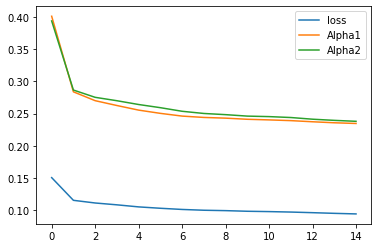

In [22]:
plt.plot(trainer.train_loss, label='loss')
plt.plot(trainer.train_alpha1, label='Alpha1')
plt.plot(trainer.train_alpha2, label='Alpha2')

plt.legend(loc='best')

plt.show()

In [23]:
#s=20; e=380

#plt.xticks(rotation=45)
#plt.plot(lrs[s:e], losses[s:e])


In [24]:
#plt.xticks(rotation=45)
#plt.plot(lrs[s:e], alpha_losses1[s:e])
#lrs, losses, alpha_losses1, alpha_losses2

In [25]:

#plt.xticks(rotation=45)
#plt.plot(lrs[s:e], alpha_losses2[s:e])
#lrs, losses, alpha_losses1, alpha_losses2

In [26]:

#plt.xticks(rotation=45)
#plt.plot(lrs[s:e], consistency_losses[s:e])
#lrs, losses, alpha_losses1, alpha_losses2
